### 🎯 CYCLE GOAL

Identify clusters through the variables used in RFM segmentation, a quick and easy method with valuable business data that every invoice issuing business has. RFM stands for recency, frequency and monetary value. These RFM metrics are important indicators of customer behavior because frequency and monetary value affect the lifetime value of a customer and recency affects retention, a measure of engagement. The result of this clustering will serve as the basis for checking progress.

Recency refers to the amount of time since a customer's last interaction with a brand, which can include their last purchase, a visit to a website, use of a mobile app, a "like" on social media, and more. Recency is an important metric because customers who have interacted with your brand more recently are more likely to respond to new marketing efforts.
 
Frequency refers to the number of times a customer has made a purchase or interacted with your brand during a given period of time. Frequency is an important metric because it shows how deeply a customer is engaged with your brand. Higher frequency indicates a higher degree of customer loyalty.

Monetary value refers to the total amount a customer has spent buying your brand's products and services over a given period of time. Monetary value is an important metric because customers who have spent more in the past are more likely to spend more in the future.


# 0.0 IMPORTS

In [1]:
import numpy                 as np
import pandas                as pd

import seaborn               as sns
import matplotlib.patches    as mpatches
import scikitplot            as skplt
import plotly.express        as px
import umap.umap_            as umap

from sklearn import cluster  as c
from sklearn import metrics  as m

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML
from IPython.display         import Image


from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def personal_settings():   
    display(HTML('<style>.container{width:80% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.mode.chained_assignment = None
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
    
    sns.set()

In [3]:
personal_settings()

## 0.2 Load Data

In [4]:
df_raw = pd.read_csv('../data/OnlineRetail.csv')

# 1 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


## 1.1 Data Dimensions

In [7]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

541909 rows
8 columns


## 1.2 Rename columns

In [8]:
df1.columns 

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Descriptions

* `invoice_no` | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter `c`, it indicates a cancellation. 
* `stock_code` | A 5-digit integral number uniquely assigned to each distinct product.   
* `description` | Product name. 
* `quantity` | The quantities of each product (item) per transaction.  
* `invoice_date` | The day and time when each transaction was generated.    
* `unit_price` | Product price per unit in sterling.
* `customer_iD` | A 5-digit integral number uniquely assigned to each customer.    
* `country` | The name of the country where each customer resides.   

## 1.3 Data Types

In [10]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,invoice_no,object,25900,"[555839, 538371]"
1,stock_code,object,4070,"[90214K, 22620]"
2,description,object,4223,"[EMPIRE DESIGN ROSETTE, SMALL PARLOUR FRAME]"
3,quantity,int64,722,"[-32, 109]"
4,invoice_date,object,23260,"[2011-07-07 15:41:00, 2011-09-05 12:21:00]"
5,unit_price,float64,1630,"[3.95, 141.5]"
6,customer_id,float64,4372,"[14080.0, 12838.0]"
7,country,object,38,"[Switzerland, Lebanon]"


## 1.4 Check NA

In [11]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data = description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,invoice_no,0,0
1,stock_code,0,0
2,description,1454,0
3,quantity,0,0
4,invoice_date,0,0
5,unit_price,0,0
6,customer_id,135080,25
7,country,0,0


## 1.5 Replace NA

As this is the first cycle, our goal is to get a premilinar analysis of possible clusters, we will eliminate the lines with null values, and in another cycle we will think about replacing the null values.

In [12]:
df1.dropna(subset=['description', 'customer_id'], inplace=True)

df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [13]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.normalize()

# customer_id
df1['customer_id'] = np.int64(df1['customer_id'])

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [15]:
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom


# 2 FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 Features Creation

In [17]:
# reference table
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
                   'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [18]:
# gross revenue
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# recency
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [19]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3 DATA FILTERING

In [20]:
df3 = df_ref.copy()

# 4 EXPLORATORY DATA ANALYSIS

In [21]:
df4 = df3.copy() 

# 5 DATA PREPARATION

In [22]:
df5 = df4.copy()

# 6 FEATURES SELECTION

In [23]:
df6 = df5.copy()

# 7 HYPERPARAMETER FINE TUNNING

In [24]:
df7 = df6.copy()

In [25]:
X = df7.drop(columns=['customer_id'])

clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

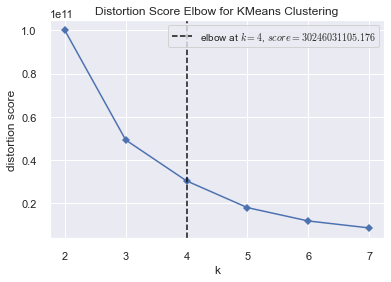

In [26]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

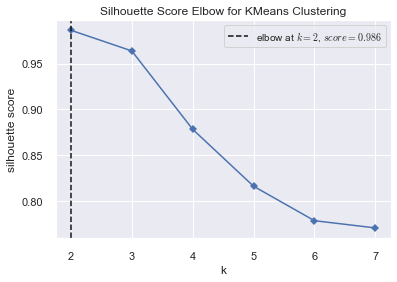

In [27]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)

kmeans.show();

## 7.3 Silhouette Analysis

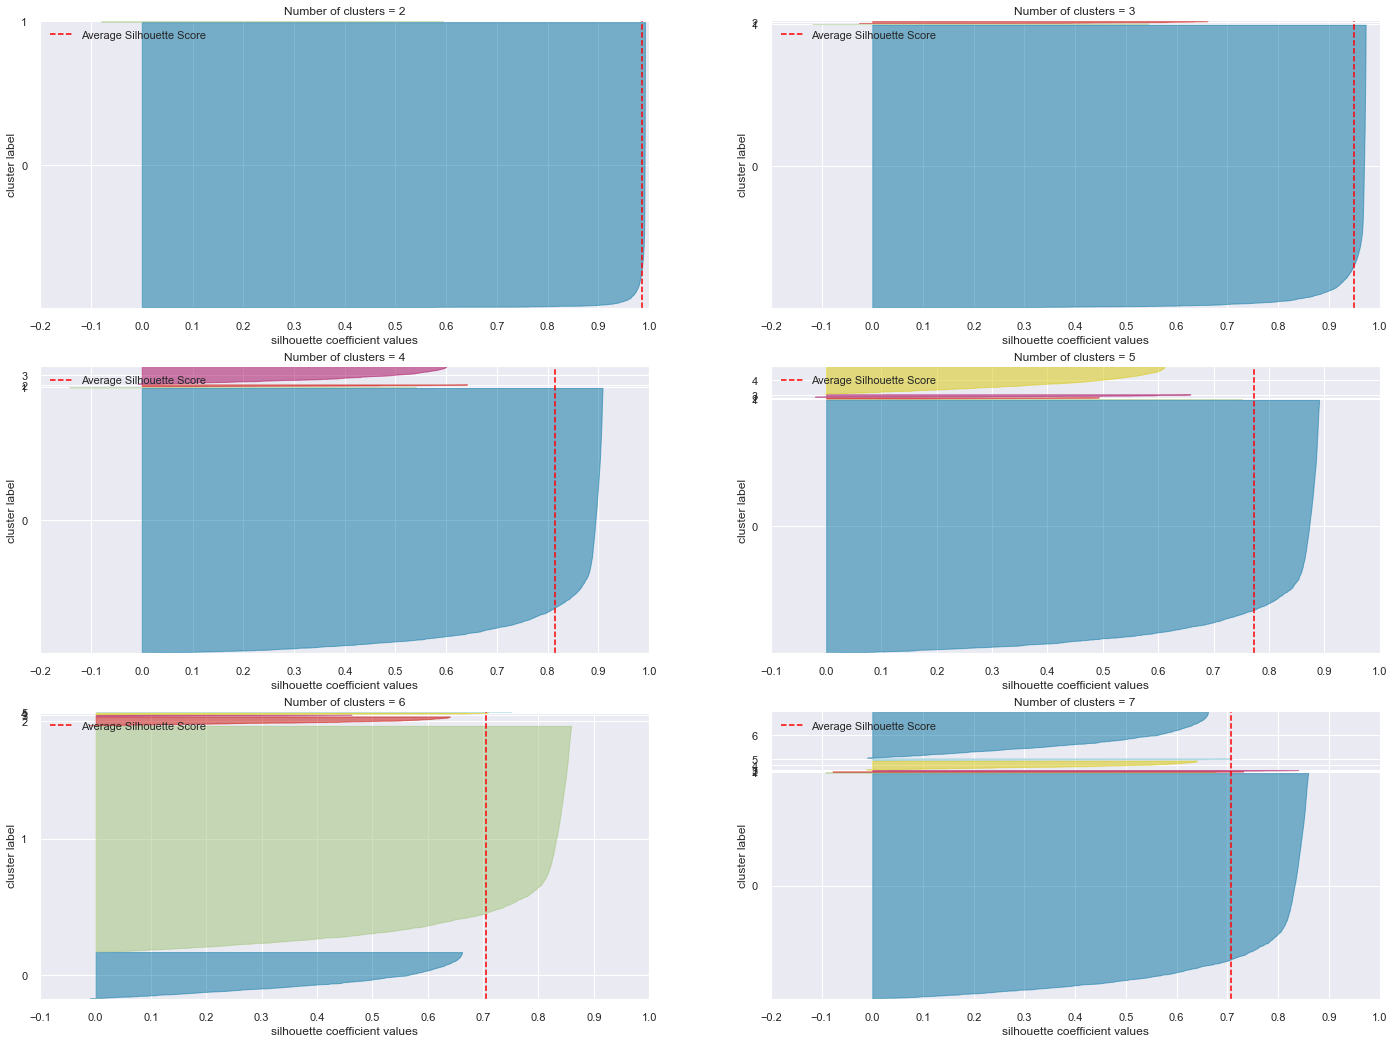

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(24, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
    
ax[0, 0].title.set_text('Number of clusters = 2')
ax[0, 1].title.set_text('Number of clusters = 3')
ax[1, 0].title.set_text('Number of clusters = 4')
ax[1, 1].title.set_text('Number of clusters = 5')
ax[2, 0].title.set_text('Number of clusters = 6')
ax[2, 1].title.set_text('Number of clusters = 7')

plt.show()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [29]:
# model definition
k = 3  
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [30]:
## WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

##SS
print(f'SS : {m.silhouette_score(X, labels, metric="euclidean"):.2f}')

WSS: 52830442008.01
SS : 0.95


# 9 CLUSTER ANALYSIS

In [31]:
df9 = df_ref.copy()
df9['cluster'] = labels

df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## 9.1 2D Plot

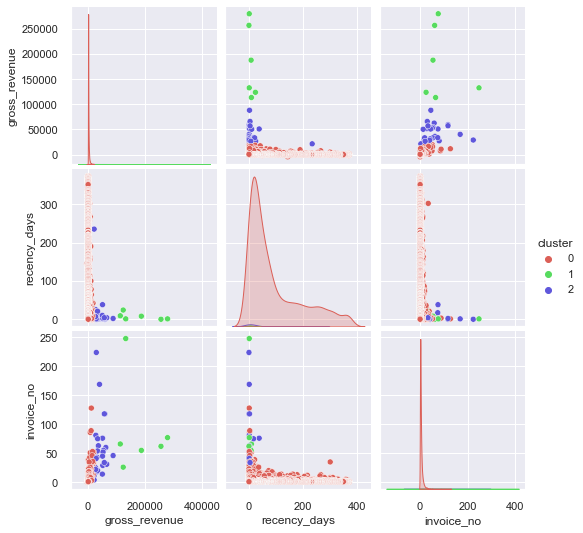

In [32]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())));

## 9.2 Cluster Profile

In [33]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qnt_customers'})
df_cluster['perc_customer'] = df_cluster['qnt_customers'] / (df_cluster['qnt_customers'].sum()) * 100

# avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster')

In [34]:
df_cluster

,cluster,qnt_customers,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.15,1372.58,92.26,4.61
1,1,6,0.14,182181.98,7.17,89.00
2,2,31,0.71,40543.52,13.29,53.29
